In [1]:
# 使用するライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# フィルタを適用する（畳み込み）
def convolve(hs, xs):
    N = len(xs)		# 信号の長さ
    M = len(hs)		# フィルタのタップ数
    ys = np.zeros(len(xs), dtype=np.complex128) # 結果を保存する領域
    for n in range(len(xs)):
        for m in range(len(hs)):
            ys[n] += xs[n-m] * hs[m] if n-m >= 0 else 0

    return ys

In [3]:
hs = np.array([+1,+2,+3])
xs = np.array([+1,-1,+2,0,0,0,0,0,])
ys = convolve(hs, xs)
ys

array([1.+0.j, 1.+0.j, 3.+0.j, 1.+0.j, 6.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [4]:
hs = np.array([+1,0, +0.22,0,-0.05])
xs = np.array([+1,0,-1,0,+1,0,0,0,0])
ys = convolve(hs, xs)
np.real(ys)

array([ 1.  ,  0.  , -0.78,  0.  ,  0.73,  0.  ,  0.27,  0.  , -0.05])

In [5]:
def make_rect_imp_resp(nOS, nDesign, nTaps):
    fs = np.linspace(-nOS/2, nOS/2, num=nOS*nDesign, endpoint=False)

    # H[k]を作る
    hk = np.zeros(fs.shape, dtype=np.float64)
    hk[(-1/2 <= fs) & (fs < 1/2)] = 1

    # 逆離散フーリエ変換
    hs = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(hk)))
    
    # 中央の部分を返す
    nMid = len(fs)//2
    hs = np.real(hs)[nMid-nTaps//2:nMid+nTaps//2]
    hs = hs / np.max(hs)
    return fs, hk, (np.arange(0,nTaps)-nTaps/2)/nOS, hs


In [6]:
_, filter_freq, tau, filter_resp = make_rect_imp_resp(8, 1024, 64)
# _, filter_freq, tau, filter_resp = make_rcos_imp_resp(0.5, 8, 1024, 64)
filter_resp

array([ 0.        , -0.03143385, -0.06001844, -0.08112217, -0.09094219,
       -0.0871317 , -0.06925281, -0.03897862,  0.        ,  0.04236826,
        0.081845  ,  0.11202805,  0.12732146,  0.12382096,  0.10003356,
        0.05732244,  0.        , -0.06496564, -0.12861538, -0.1809708 ,
       -0.21220509, -0.21387509, -0.18006238, -0.10827683,  0.        ,
        0.13921329,  0.30010491,  0.47052741,  0.63661927,  0.78421296,
        0.90031614,  0.97449531,  1.        ,  0.97449531,  0.90031614,
        0.78421296,  0.63661927,  0.47052741,  0.30010491,  0.13921329,
        0.        , -0.10827683, -0.18006238, -0.21387509, -0.21220509,
       -0.1809708 , -0.12861538, -0.06496564,  0.        ,  0.05732244,
        0.10003356,  0.12382096,  0.12732146,  0.11202805,  0.081845  ,
        0.04236826,  0.        , -0.03897862, -0.06925281, -0.0871317 ,
       -0.09094219, -0.08112217, -0.06001844, -0.03143385])

In [7]:
# fs, filter_freq1, _, _ = make_rcos_imp_resp(0.01, 8, 1024, 64)
# fs, filter_freq2, _, _ = make_rcos_imp_resp(0.5, 8, 1024, 64)
# fs, filter_freq3, _, _ = make_rcos_imp_resp(1, 8, 1024, 64)
# plt.plot(fs[np.abs(fs)<1], filter_freq1[np.abs(fs)<1], label="beta=0.01")
# plt.plot(fs[np.abs(fs)<1], filter_freq2[np.abs(fs)<1], label="beta=0.5")
# plt.plot(fs[np.abs(fs)<1], filter_freq3[np.abs(fs)<1], label="beta=1.0")
# plt.legend()

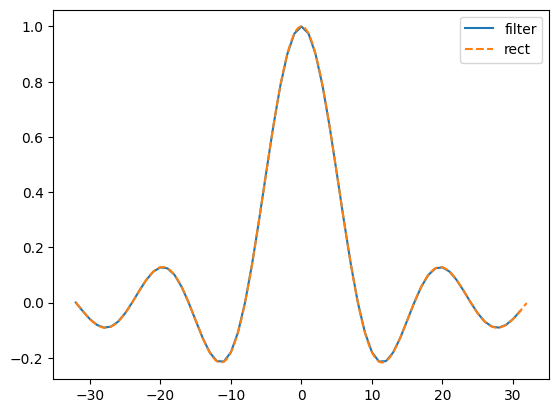

In [8]:
plt.plot(np.arange(-len(filter_resp)//2, len(filter_resp)//2), filter_resp, label="filter")

ts = np.linspace(-len(filter_resp)//2, len(filter_resp)//2, num=1024, endpoint=False) + 1e-3
plt.plot(ts, np.sin(np.pi*ts/8)/(np.pi*ts/8), linestyle="--", label="rect")
plt.legend()

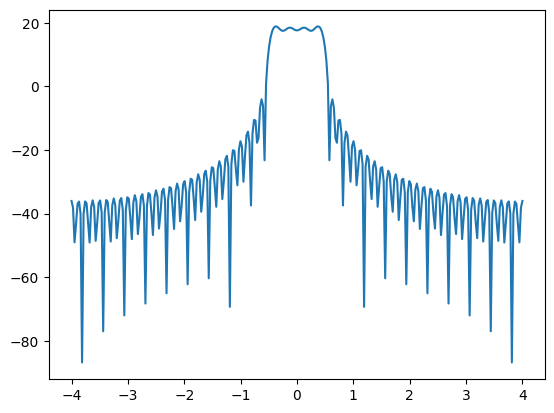

In [9]:
def analyze_freq_resp(hs, sampRate):
    fks = np.linspace(-sampRate/2, sampRate/2, num=300)
    dst = np.zeros(fks.shape, dtype=np.complex128)
    for i in range(len(hs)):
        dst += hs[i] * np.exp(-2j*np.pi*fks/sampRate * i)

    return (fks, 10*np.log10(np.abs(dst)**2))

plt.plot(*analyze_freq_resp(filter_resp, 8))

In [10]:
# 定数の定義
nSYM = 128      # シミュレーションするシンボル数
nBPS = 1        # 1シンボルあたりのビット数(BPSK = 1, QPSK = 2など)
nOS = 8         # オーバーサンプリング率

In [11]:
# 1シンボルあたりのビット数（nBPS）に応じて呼び出す関数を変える
def mod(bs):
    if nBPS == 1:
        return bpsk_mod(bs)
    elif nBPS == 2:
        return qpsk_mod(bs)
    else:
        return my_mod(bs)

# BPSKの変調をする関数の定義
@np.vectorize
def bpsk_mod(bs):
    if bs == 0:
        return +1.0
    else:
        return -1.0

In [12]:
# ランダムなビット列の生成
bs = np.random.randint(2**(nBPS), size=nSYM)
bs

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1])

In [13]:
# ビット列からBPSKの信号点へマッピングする
xs0 = mod(bs)
xs0

array([ 1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1.,
       -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.])

In [14]:
# 1シンボルあたり離散時間サンプルをnOS個用意する
# ただし，各シンボルの後に追加するのは0
xs = np.concatenate(np.hstack((xs0[:,np.newaxis], np.zeros((nSYM,nOS-1)))))
xs

array([1., 0., 0., ..., 0., 0., 0.])

In [15]:
nDelay = 0
ys = convolve(filter_resp, xs)
nDelay += len(filter_resp)//2

# ys = convolve(filter_resp, ys)
# nDelay += len(filter_resp)//2

ys

array([ 0.        +0.j, -0.03143385+0.j, -0.06001844+0.j, ...,
        0.12332161+0.j, -0.23761443+0.j, -0.62186765+0.j])

In [16]:
# フィルタでの遅延を考慮してnOSサンプルごとに取得
ys2 = ys[nDelay::nOS]
# I相の復調結果を表示する
Ids = np.zeros(len(ys2))
Ids[ys2 < 0] = 1
Ids

array([0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 0.])

In [17]:
# I相の復調結果が送信ビットと同じかチェックする
err_cnt = np.sum(Ids != bs[:len(Ids)])
print("Error: ", err_cnt, ", Error Rate: ", err_cnt / len(Ids))

Error:  0 , Error Rate:  0.0


ys = convolve()

/Users/komatsu/Library/Python/3.9/lib/python/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


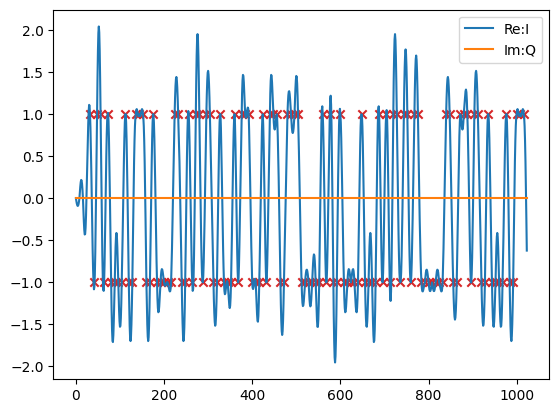

In [18]:
# ベースバンド信号を表示する
plt.plot(np.real(ys), label="Re:I")
plt.plot(np.imag(ys), label="Im:Q")

plt.scatter(np.arange(nDelay, nDelay+len(ys2)*nOS, nOS), ys2, marker='x', color='C3')
plt.legend()

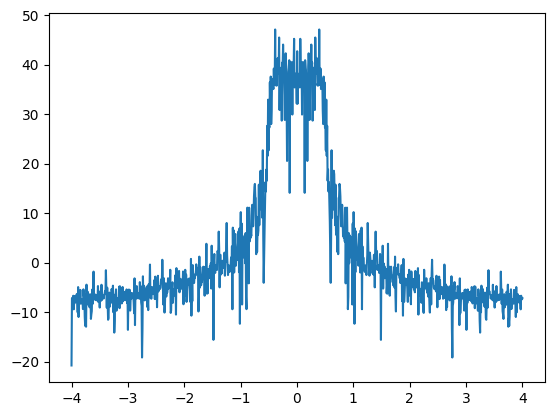

In [19]:
fs = np.linspace(-nOS/2, nOS/2, num=nOS*nSYM)
Yf = np.abs(np.fft.fft(ys))**2

plt.plot(fs, 10*np.log10(np.fft.fftshift(Yf)) )